### Step 1. Load the necessary packages

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf
import datetime 
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings('ignore')
import optuna
import time
import streamlit as st
from boruta import BorutaPy
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import plot_tree
from sklearn.feature_selection import SelectKBest,mutual_info_regression
from optuna.visualization import plot_optimization_history,plot_intermediate_values
from datetime import date
from statsmodels.tools.eval_measures import rmse
import yfinance as yf
from prophet import Prophet
from prophet.plot import plot_plotly,plot_components_plotly
from plotly import graph_objs as go
from statsmodels.tsa.seasonal import seasonal_decompose

### In this project I will work with yahoo finance database
With the help of the **yfinance** library, we can download data sets with share prices of various companies, for example:
- 'FB' Facebook
- 'AMZM' Amazon
- 'NFLX' netflix
- "GOOG" Google, etc.

### Step 2. Data preprocessing

In [2]:
try:# In this part of the project, I will download a data set of "Amazon" stock prices.
    company_name= 'AMZN'
    # Specify the time interval
    start = "2000-01-01"
    end = "2021-01-01"
    #За With the help of the library, I download the dataset
    df = yf.download(company_name,start,end)
    print(df.sample(5))
except:
    print("Something went wrong")

[*********************100%%**********************]  1 of 1 completed
               Open       High        Low      Close  Adj Close     Volume
Date                                                                      
2018-02-16  72.8685  73.290001  72.328003  72.434502  72.434502   89452000
2009-08-31   4.0965   4.097500   4.017500   4.059500   4.059500  105276000
2005-09-07   2.1750   2.215000   2.172500   2.186500   2.186500  122830000
2001-05-14   0.7265   0.726500   0.658000   0.666500   0.666500  123884000
2003-05-07   1.5330   1.543000   1.501500   1.535000   1.535000  207036000


In [3]:
#Checking whether the type of each future that I have in the date set is suitable for me
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [4]:
#Checking the date set for missing values
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
#Also for duplicates
df.duplicated().sum()

0

In [6]:
#To facilitate the work in the future, I transfer the names of all futures to the lower register
df.columns = df.columns.str.lower()
df.sample(5)

,open,high,low,close,adj close,volume
Date,,,,,,
2010-12-20,8.9635,9.199000,8.902000,9.1645,9.1645,174706000
2015-06-01,21.5200,21.658001,21.309999,21.5460,21.5460,45066000
2005-07-21,1.9480,1.987500,1.888000,1.8975,1.8975,221112000
2002-06-24,0.8715,0.889000,0.847000,0.8755,0.8755,119136000
2013-08-28,14.0180,14.150000,13.966500,14.0790,14.0790,29142000


### Step 3. Exploration Data Analysis

In [7]:
#With the help of the "describe" function, I will get a statistical analysis of my data set
df.describe()

,open,high,low,close,adj close,volume
count,5284.000000,5284.000000,5284.000000,5284.000000,5284.000000,5.284000e+03
mean,23.608661,23.870707,23.315686,23.605274,23.605274,1.294548e+08
std,35.901267,36.294316,35.437523,35.879222,35.879222,1.022309e+08
min,0.295500,0.305000,0.275500,0.298500,0.298500,1.762600e+07
25%,2.076875,2.127969,2.045000,2.084375,2.084375,7.248250e+07
50%,6.703250,6.802000,6.605250,6.703500,6.703500,1.070230e+08
75%,26.736251,26.986375,26.361001,26.715000,26.715000,1.544395e+08
max,177.350006,177.612503,174.334503,176.572495,176.572495,2.086584e+09


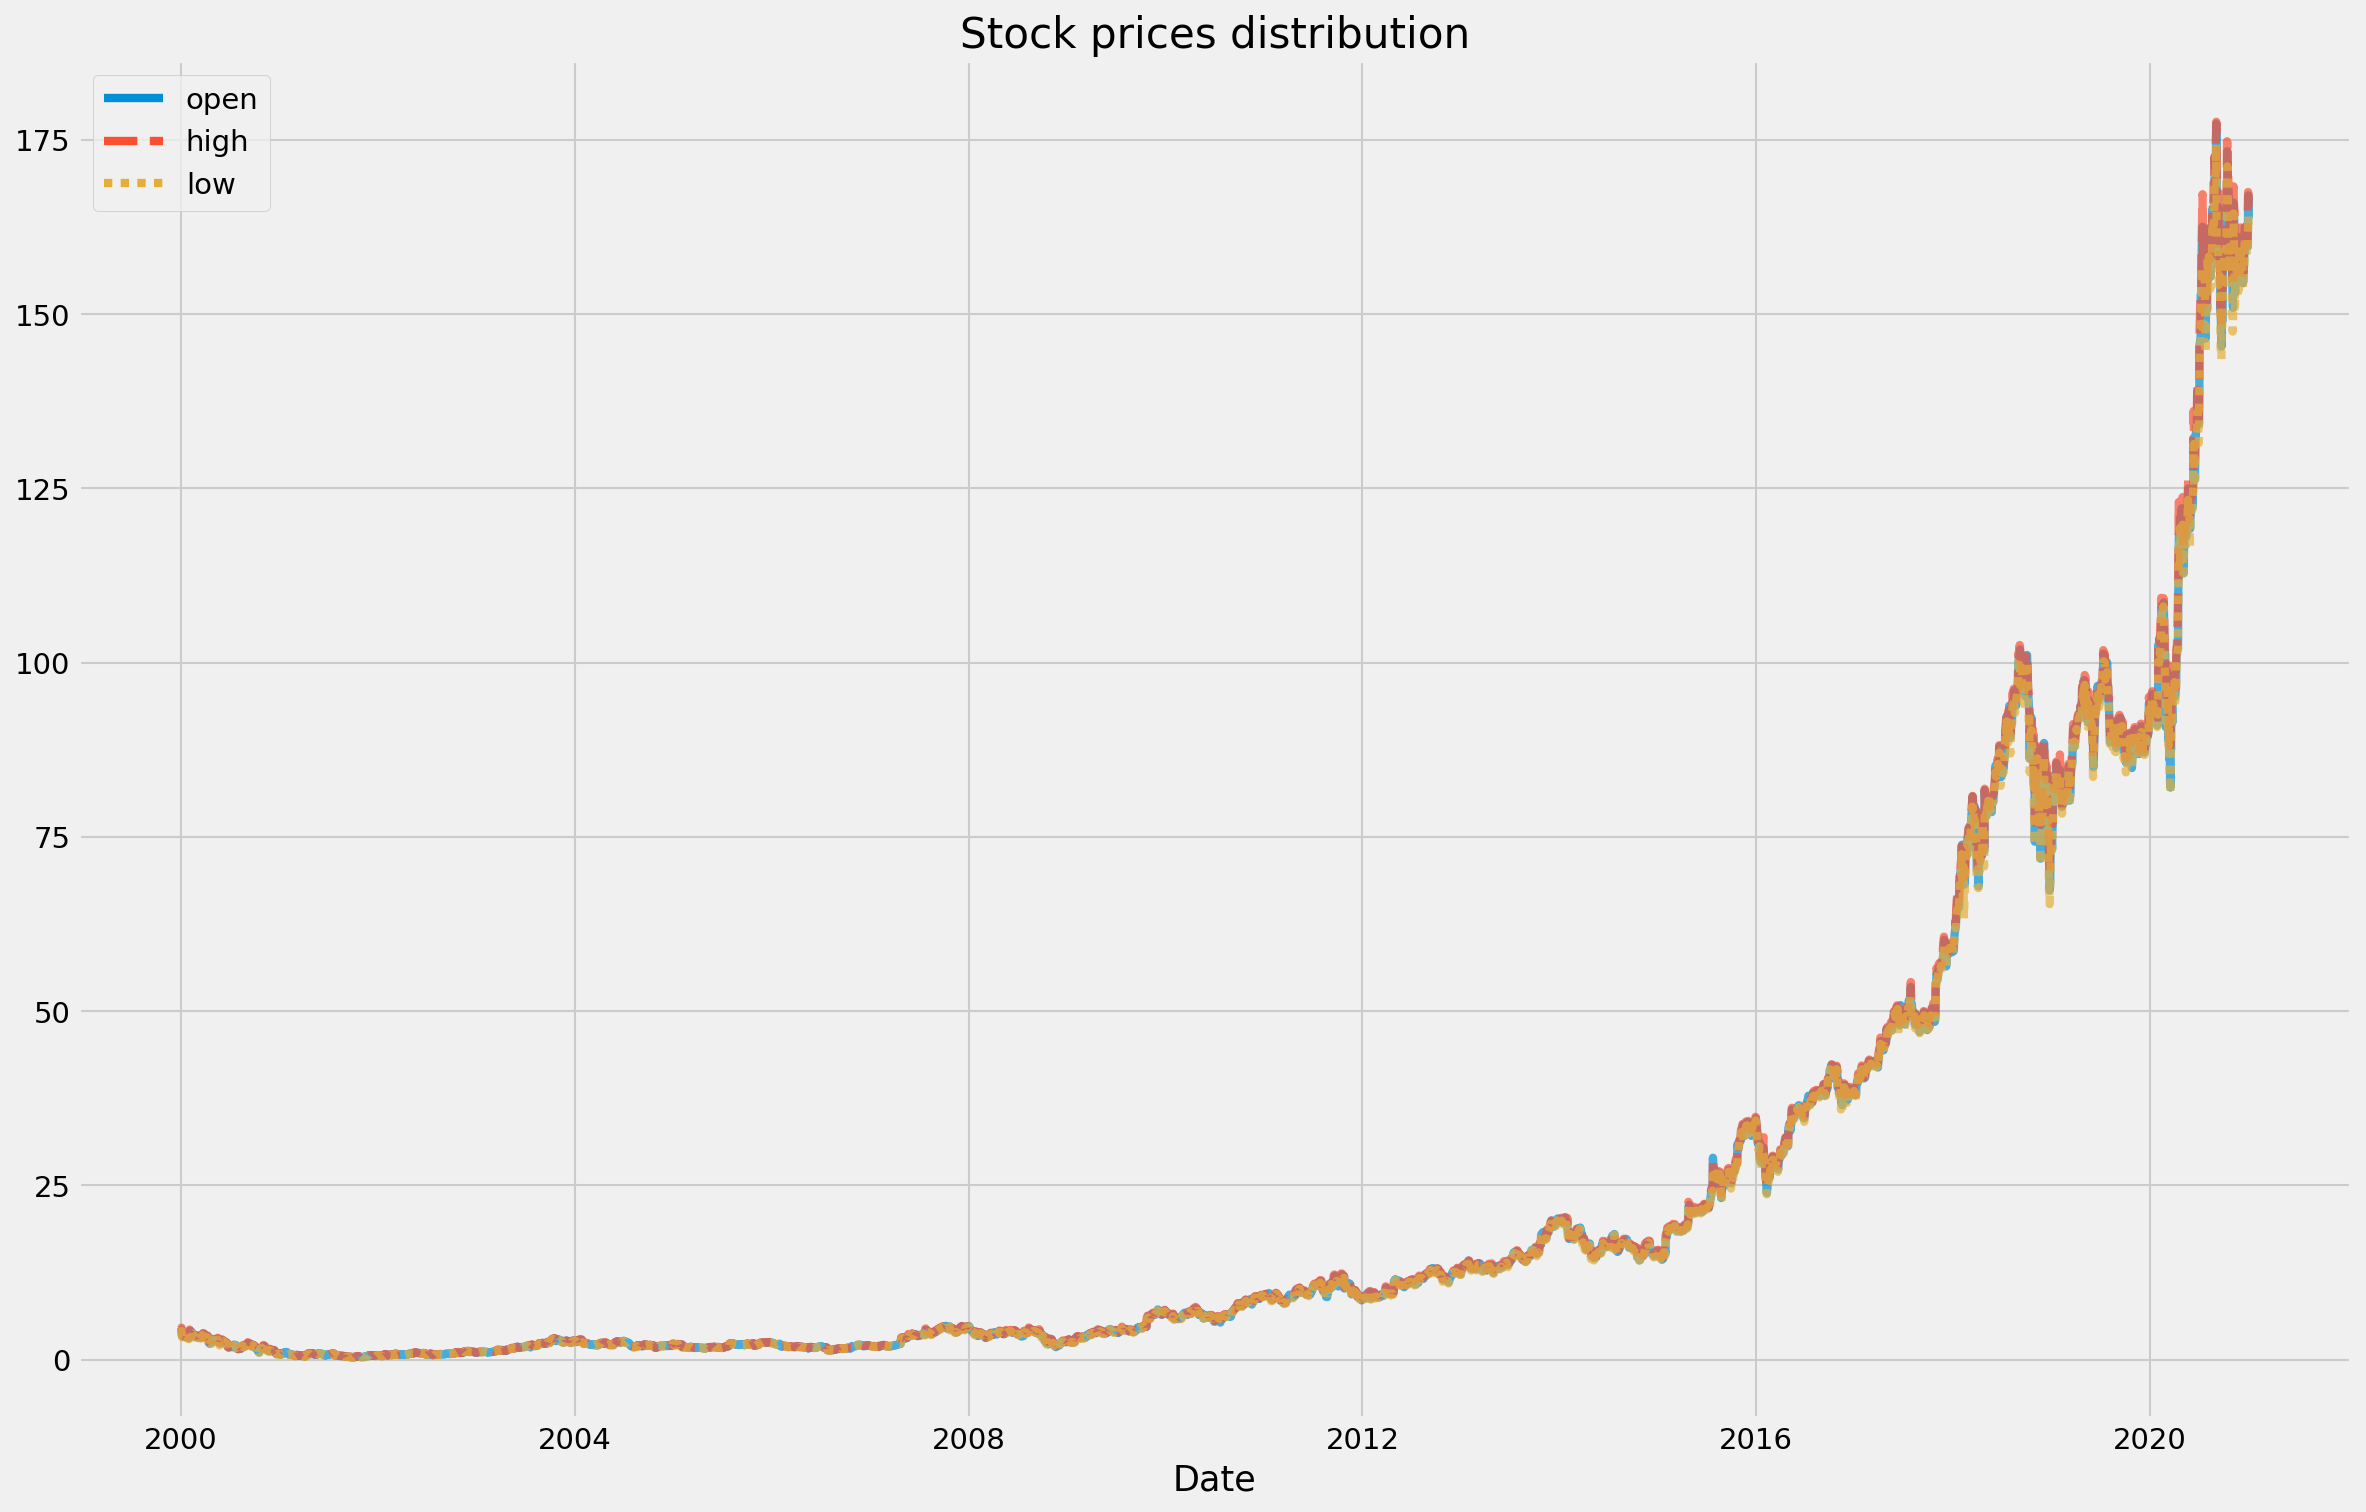

In [8]:
#I propose to build several graphs that show how prices have changed
#per promotion during our timeframe
plt.figure(figsize=(16, 10), dpi=150) 
sns.lineplot(df[['open','high','low']], alpha=0.7)
plt.tight_layout()
plt.title("Stock prices distribution")
plt.show()

> From the previous graph, it can be seen that I have quite similar indicators in each of the **futures**, and it is also clear that after 2016, the prices of ***amazon** shares went uphill rapidly

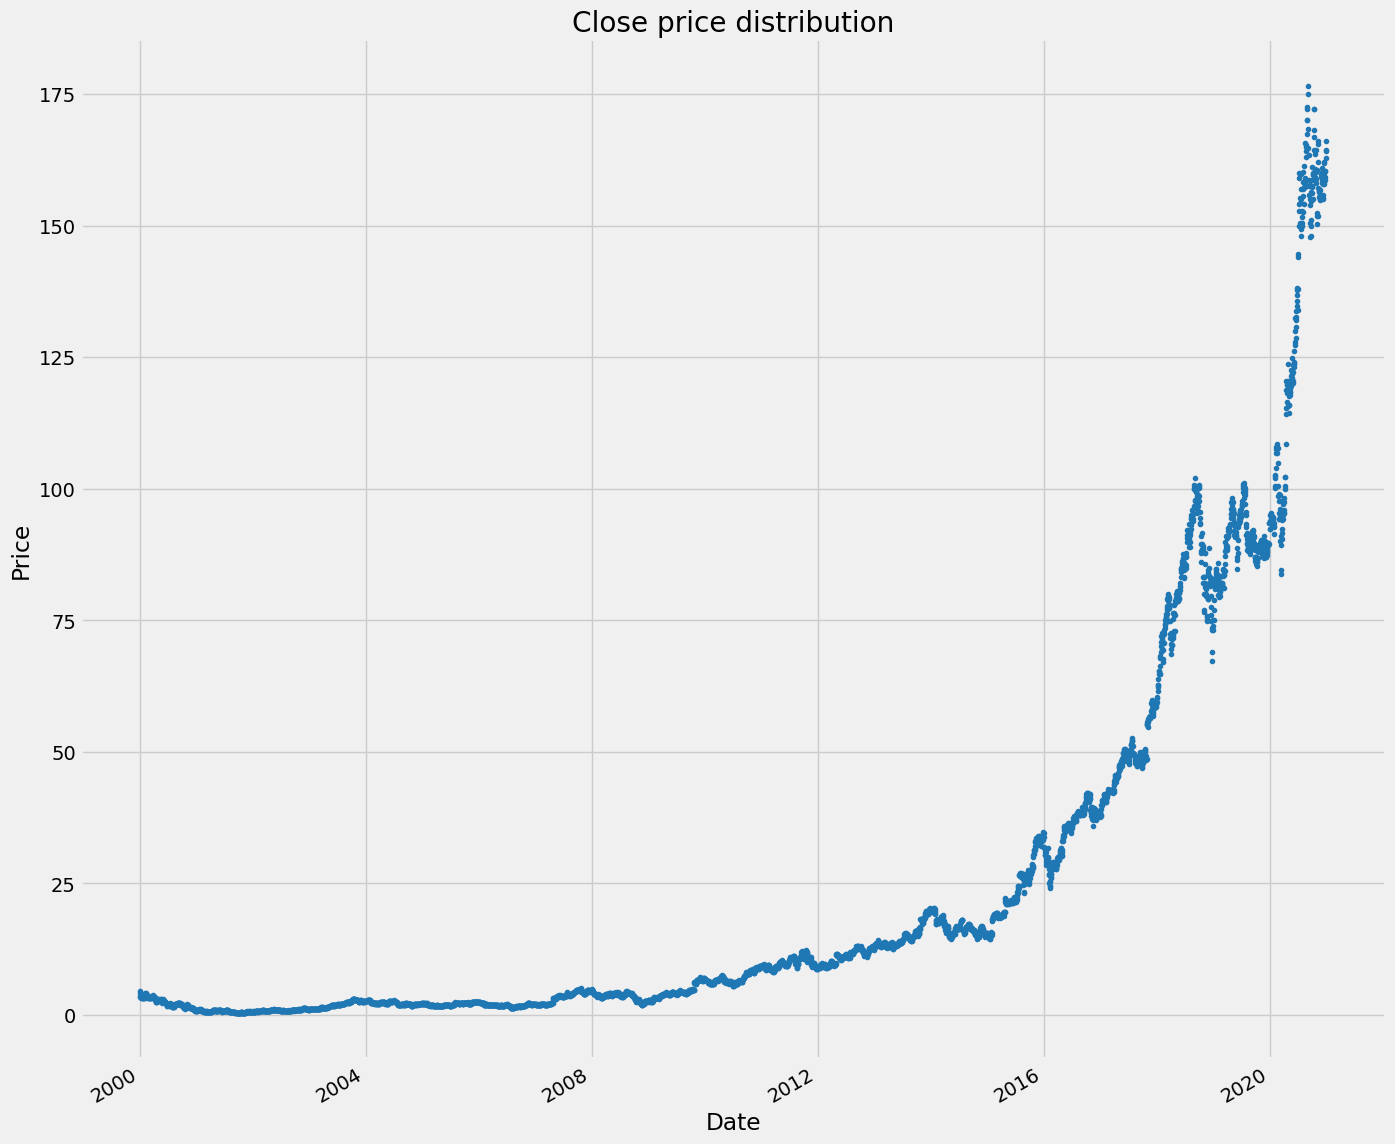

In [9]:
#Chart of final prices for the company's shares
df['close'].plot(style='.', figsize=(15,15),color = color_pal[0],title='Close price distribution')
plt.ylabel('Price')
plt.xlabel('Date')
plt.show();

>From this graph, it can be seen that before **2008** the price of shares was approximately in the same price range, but after **2008** they began to grow rapidly, between **2016** and **2020** a couple of times reached their peak thresholds and sometimes fell in price, but after **2020** they began to rapidly fly uphill

To understand whether there are patterns in my data, I am building a time series **trends and seasonality** based on the data of 2018 for half a year.

- **Trend** is a smooth change in the average value of a series without repeating regularities. For example, annual growth in air ticket sales.
- **Seasonality**- means cyclically repeating patterns in a time series. For example, the increase in air ticket sales every summer.



In [10]:
#Creating a new data set for building the following graphs
data = df['close'].sort_index()
data= data['2018-01':'2018-06'].resample('1D').sum()

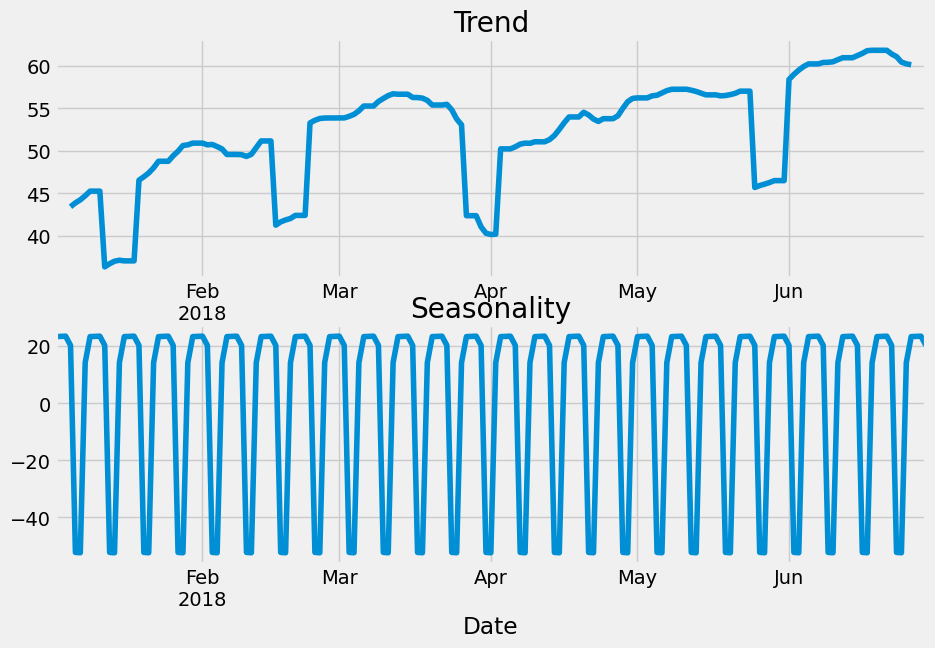

In [11]:
#Applying the "seasonal_decompose" function to my data set to get the required variables
# for further determination of regularities
decomposed = seasonal_decompose(data['2018-01-01':'2018-06-01'])
decomposed = seasonal_decompose(data)
plt.figure(figsize=(10,10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
print()
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.show()

- It can be seen from the previous two graphs that in each month I have peaks and valleys, that is, the prices were not stable, but it is clearly visible that after each valley they had a tendency to increase

In [12]:
# Using the "boxplot" graph, I check whether my data set has many outliers
# but first we need to divide our data set into 2 parts, since we can see from the previous graphs that before 2016 the prices were much lower than after
data_till_2016 = df.loc['2000-01-03':'2016-01-01']# till 2016 
data_after_2016 = df.loc['2016-01-01':]#after 2016 

def plot_box(data,col,date):#Creating a function with the help of which we will build our box graph
    fig,ax= plt.subplots(figsize=(10,8))
    plt.title(f'Stock price {date}')
    plt.ylabel('Price')
    return sns.boxplot(data=data.drop(col,axis=1))#removing "volume" futures because there is a very big difference in the distribution of values compared to futures
    

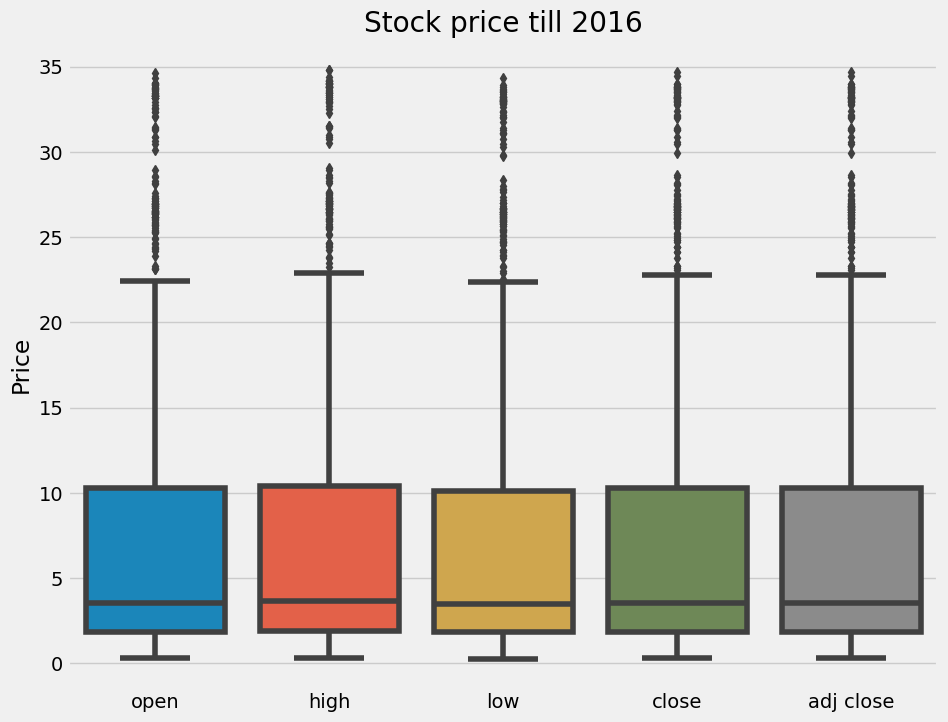

In [13]:
plot_box(data_till_2016,'volume','till 2016');

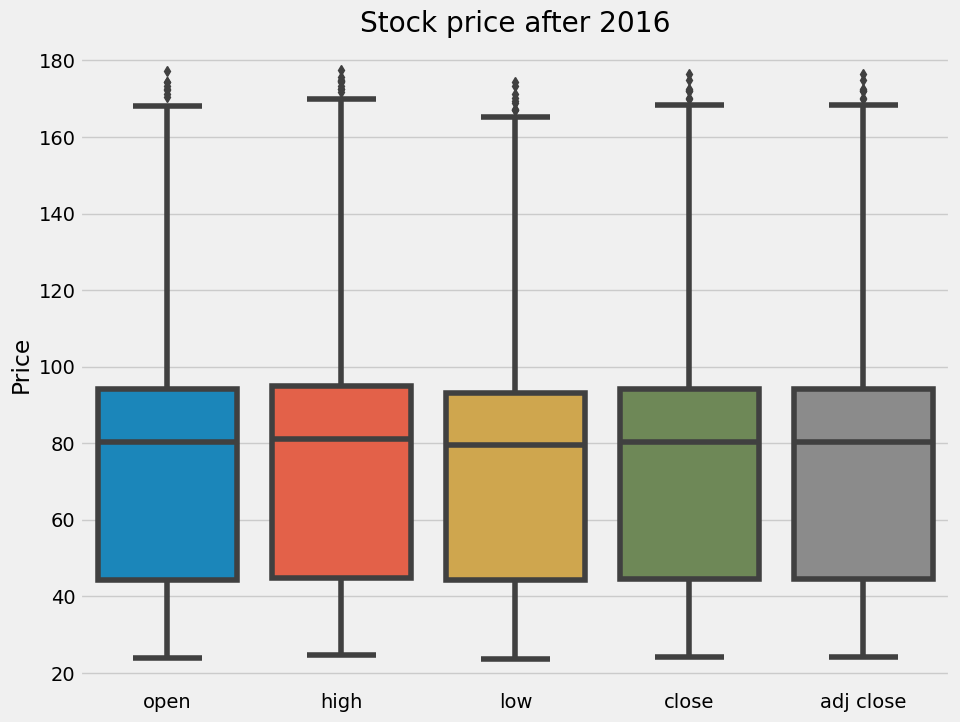

In [14]:
plot_box(data_after_2016,'volume','after 2016');

In [15]:
#The function that will show how many extreme values I have in one and another annual range
def out_perc(data,col_name):
    q1 = data[col_name].quantile(0.25)#The value located at the 25th percentile of our data in the column.
    q3 = data[col_name].quantile(0.75)#The value located at the 75th percentile of our data in the column.
    iqr = q3-q1 #The interquartile range is the spread of the middle 50% of the data
    fence_low  = q1-1.5*iqr# Minimum range of values
    fence_high = q3+1.5*iqr# Maximum range of values
    df_out = data.loc[(data[col_name] > fence_low) & (data[col_name] < fence_high)]
    outliers = len(data) - len(df_out)
    return print('The percentage of extreme values in our change "Close" is equal {:.2%}'.format( outliers / len(data)))


#calling the pre-created function to show how many extreme values each time interval has
out_perc(data_till_2016,'close')
print()
out_perc(data_after_2016,'close')

The percentage of extreme values in our change "Close" is equal 2.98%

The percentage of extreme values in our change "Close" is equal 0.64%


>From the previous box graphs, I conclude that after 2016, the regularity in the distribution of prices has better indicators due to the fact that there are practically no critical (outlier) values. But to generalize, it is possible to assume that the prices changed over the years, but in our futures the price range remained practically the same, this can be seen from the fact that the **median** is practically at the same level in all cases in one and another box graph

In [16]:
def create_features(data):
    """Creation of new "futures" based on the time series index"""
    data = data.copy()
    data['dayofweek'] = data.index.dayofweek
    data['quarter'] = data.index.quarter
    data['month'] =data.index.month
    data['year'] = data.index.year
    return data

In [17]:
#Applying the previous function to my date set
df = create_features(df)
df.sample(5)

,open,high,low,close,adj close,volume,dayofweek,quarter,month,year
Date,,,,,,,,,,
2018-10-01,101.099503,101.659500,100.180000,100.218002,100.218002,69210000,0,4,10,2018
2004-03-02,2.136500,2.174500,2.093000,2.100500,2.100500,139332000,1,1,3,2004
2013-03-20,12.902500,12.988000,12.727500,12.864000,12.864000,54778000,2,1,3,2013
2018-08-09,94.099998,95.728500,93.874001,94.926003,94.926003,97208000,3,3,8,2018
2000-02-09,4.027344,4.186719,4.000781,4.012500,4.012500,191608000,2,1,2,2000


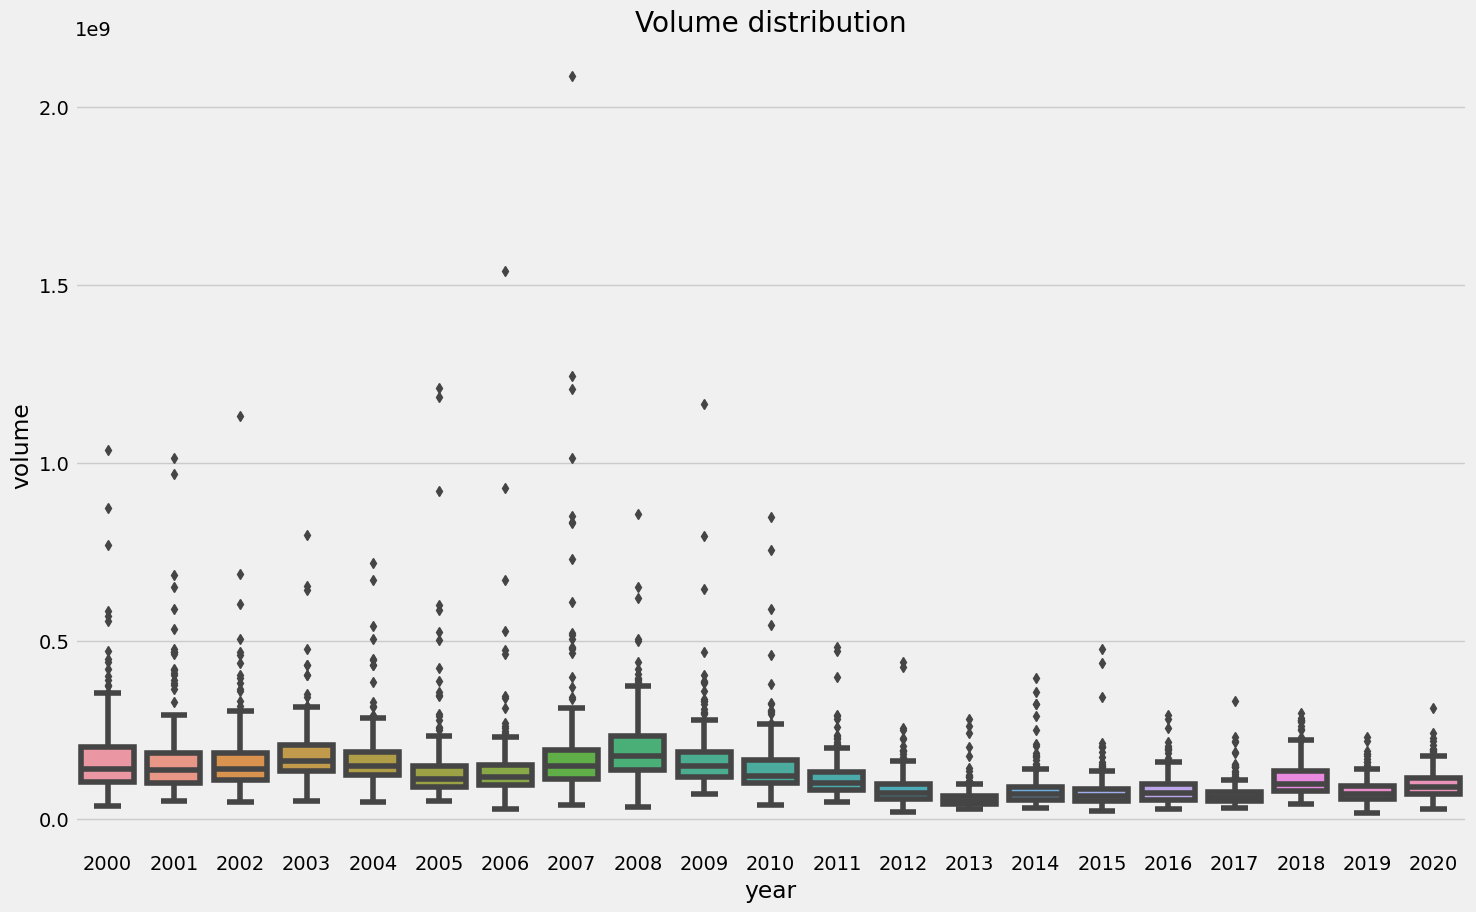

In [18]:
#Let's build the last box plot for my "volume" futures
fig,ax= plt.subplots(figsize=(16,10))
sns.boxplot(data=df, x='year', y='volume')
ax.set_title('Volume distribution');

>From the latest box plot, it is clear that the number of shares sold after 2011 started to decrease

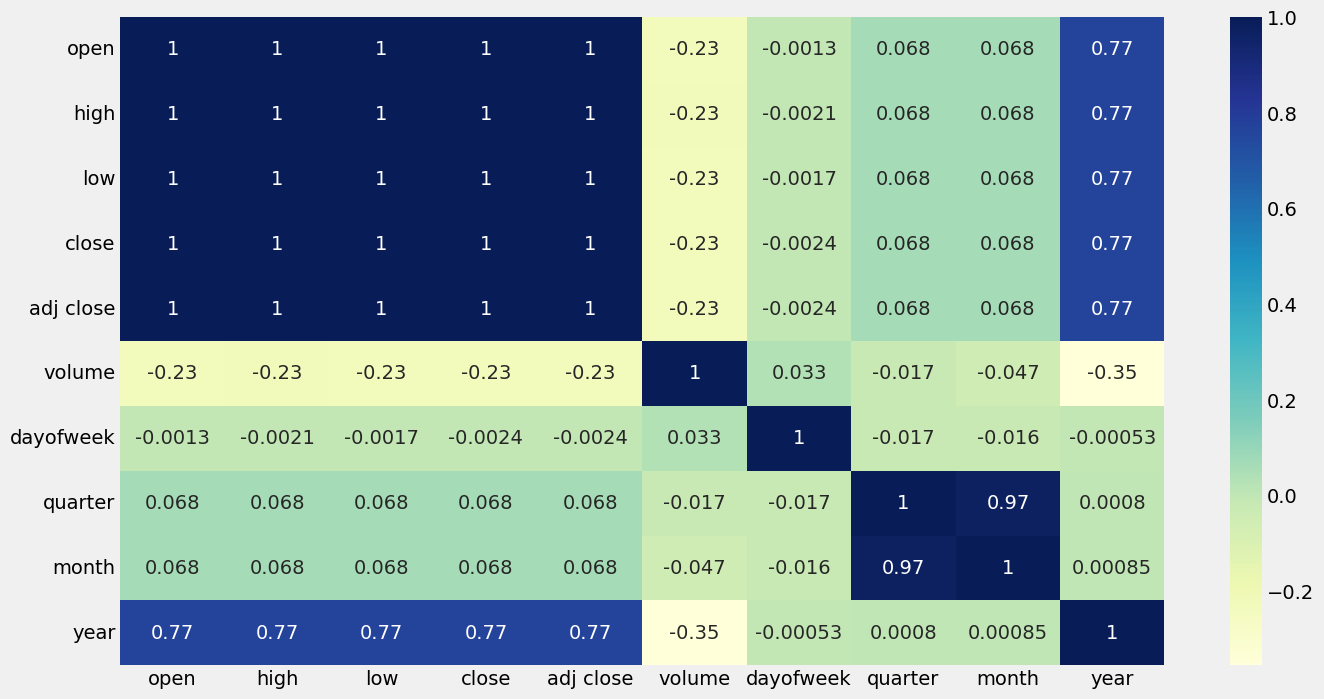

In [19]:
#I determine existing patterns and correlations.
#Building a correlation heat map of our dataset
plt.figure(figsize = (15,8))
sns.heatmap(df.corr(),annot=True,cmap="YlGnBu");

> The correlation heat map shows a direct dependence on some futures in my data set, as well as an opposite dependence of our target variable.

### Step 4.1. Preparation of the data set for working with the model

In [20]:
#dividing the data set into X and y variables
X = df.drop(['close','adj close'],axis=1)
y = df['close']


In [21]:
#Standardize (normalize) data in one range to improve model performance
scaler= StandardScaler()#setting standardizer
X_scaler = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)#Normalize the data and convert it into a dataframe
X_scaler

,open,high,low,volume,dayofweek,quarter,month,year
0,-0.544145,-0.534365,-0.546460,1.887056,-1.443851,-1.358014,-1.617297,-1.652757
1,-0.538748,-0.531696,-0.542645,2.155063,-0.729563,-1.358014,-1.617297,-1.652757
2,-0.559467,-0.554257,-0.562047,6.257929,-0.015275,-1.358014,-1.617297,-1.652757
3,-0.558335,-0.557615,-0.567692,2.402487,0.699012,-1.358014,-1.617297,-1.652757
4,-0.564342,-0.560629,-0.564605,0.789006,1.413300,-1.358014,-1.617297,-1.652757
...,...,...,...,...,...,...,...,...
5279,3.790931,3.753816,3.813672,-0.982348,0.699012,1.333227,1.593105,1.650756
5280,3.791070,3.894347,3.818879,-0.153772,-1.443851,1.333227,1.593105,1.650756
5281,3.952556,3.958620,3.972022,-0.313015,-0.729563,1.333227,1.593105,1.650756
5282,3.995818,3.946840,3.973786,-0.638505,-0.015275,1.333227,1.593105,1.650756


In [22]:
#dividing the data set into two parts for working with the algorithm
X_train, X_valid, y_train, y_valid = train_test_split(X_scaler,y, test_size=0.25, random_state= 12345)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(3963, 8)
(3963,)
(1321, 8)
(1321,)


### Step 4.2. Feature selection

In this step, I will use two methods:
- Filter method (earlier I already determined with the help of correlation which futures affect the target variable.) but I will add one more in order not to manually select our futures, but with the help of filtering methods
- Wrapped here I will use the automatic selection method **Boruta**

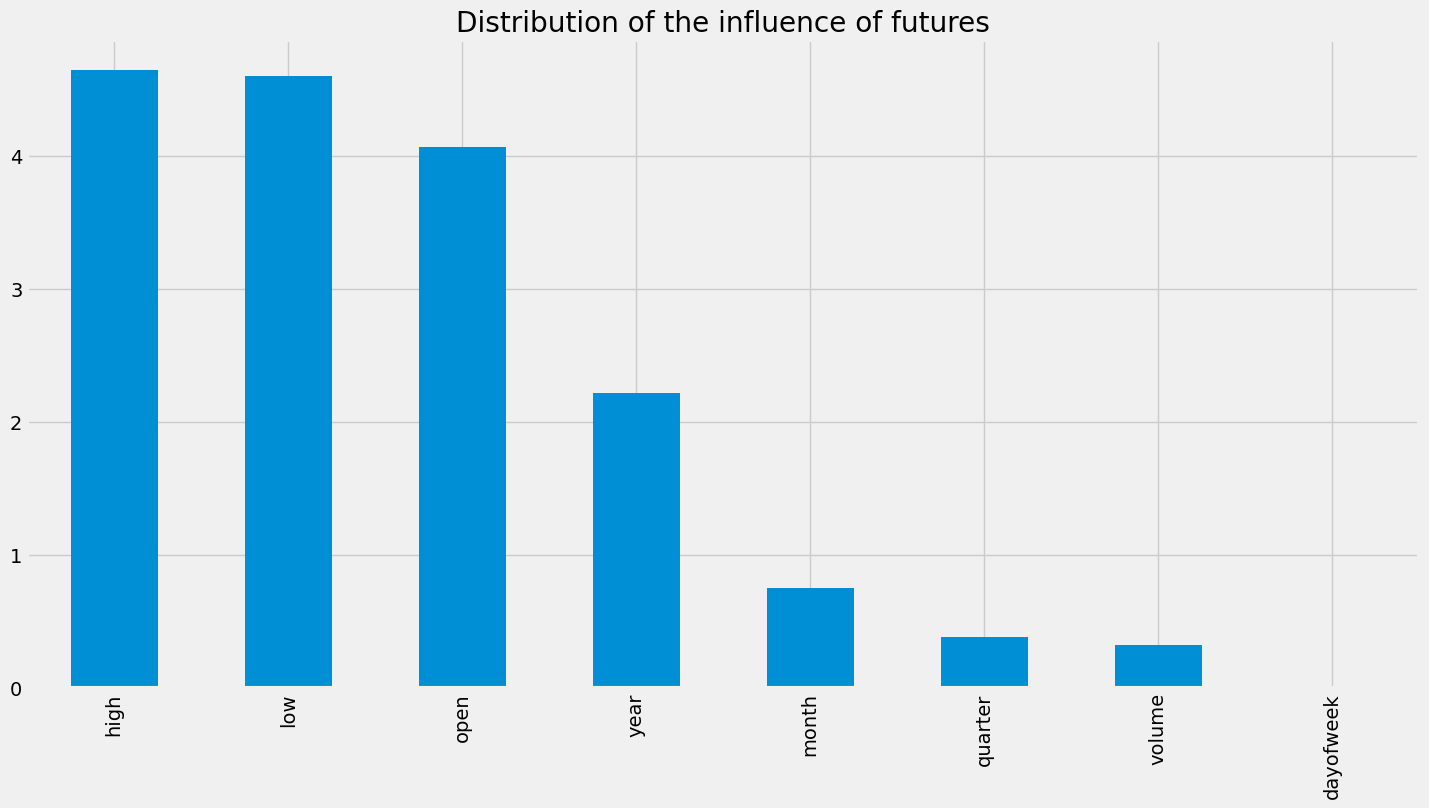

In [23]:
#Then I start working with variables for selection
mutual_info = mutual_info_regression(X_train,y_train)
mutual_info= pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False).plot.bar(figsize=(16,8))
plt.title('Distribution of the influence of futures');


In [24]:
#Determine the best 4 futures from the previous chart for automatic selection
def feature_select(X,y):
    selector = SelectKBest(mutual_info_regression,k=4)
    selector.fit(X,y)
    selected_features_mask = selector.get_support()

    selected_features = X.columns[selected_features_mask]
    return selected_features

selected_features = feature_select(X_train,y_train)
selected_features 

Index(['open', 'high', 'low', 'year'], dtype='object')

In [25]:
np.int=np.int_
np.float=np.float_
np.bool=np.bool_

In [26]:
#Selection of futures using the automatic borut method and the use of the XGB algorithm
model = xgb.XGBRegressor()#Creating a model
feat_selector = BorutaPy(model,n_estimators='auto',verbose=True,random_state=1234)#Creating a futures selection model
feat_selector.fit(X_train.values,y_train.values.ravel())

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100


BorutaPy finished running.

Iteration: 	27 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	4


BorutaPy(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                feature_types=None, gamma=None, gpu_id=None,
                                grow_policy=None, importance_type=None,
                                interaction_constraints=None,
                                learning_rate=None, max_bin=None,
                                max_cat_threshold=None, max_cat_to_onehot=None,
                                max_delta_step=None, max_depth=None,
                                max_leaves=None, min_child_weight=None,
                                missing=nan, monotone_constraints=None,
                                n_estimators=28, n_jobs=None,
                                num_parallel_tree=None, predictor=None,
                                random_state=1042817428, ...),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x2C35B7640,
         verbose=True)

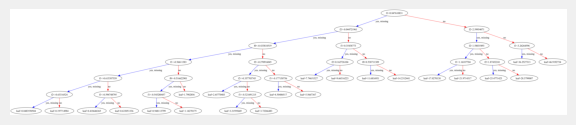

In [27]:
# Since there were too many distributions on trees during the selection of futures, it turned out to be incomprehensible at first glance
#Picture, but with the help of "num_trees" it is possible to set the number of trees displayed on the screen
plot_tree(model);


In [28]:
#Showing the rank of each futures
rank = pd.Series(feat_selector .ranking_)
col = pd.Series(X.columns)
pd.concat([col,rank],axis=1)

,0,1
0,open,1
1,high,1
2,low,1
3,volume,3
4,dayofweek,2
5,quarter,3
6,month,5
7,year,1


In [29]:
# Creation of the final version of the set of futures for working with the model
X_upd = X_scaler[selected_features]
X_upd

,open,high,low,year
0,-0.544145,-0.534365,-0.546460,-1.652757
1,-0.538748,-0.531696,-0.542645,-1.652757
2,-0.559467,-0.554257,-0.562047,-1.652757
3,-0.558335,-0.557615,-0.567692,-1.652757
4,-0.564342,-0.560629,-0.564605,-1.652757
...,...,...,...,...
5279,3.790931,3.753816,3.813672,1.650756
5280,3.791070,3.894347,3.818879,1.650756
5281,3.952556,3.958620,3.972022,1.650756
5282,3.995818,3.946840,3.973786,1.650756


> As we can see, the filtering method and the automatic method showed that it is best to use 4 futures with rank **1**

### Step 5. Working with models
- Xgboost
- LSTM
- Optuna: a method for determining the best hyperparameters

In [30]:
#Dividing the variables into subvariables for further work with the model
X_train, X_valid, y_train, y_valid= train_test_split(X_upd, y, test_size=0.25, random_state= 12345)

In [31]:
#Working with the XGboost model
def objective(trial):#Providing a different range of hyperparameters that optuna will work with
    params = {
        "objective": "reg:squarederror",
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_valid)
    mae =  mean_absolute_error(y_valid, predictions)
    return mae

In [32]:
#Training the model and finding the best set of parameters
study = optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=10)

[I 2023-10-15 22:32:32,851] A new study created in memory with name: no-name-1e1c74b4-e49d-49d2-a44e-541a9d60f34b
[I 2023-10-15 22:32:33,306] Trial 0 finished with value: 0.5701700018536945 and parameters: {'learning_rate': 0.0173514864902253, 'max_depth': 2, 'subsample': 0.5762079707001728, 'colsample_bytree': 0.2148483394821592, 'min_child_weight': 3}. Best is trial 0 with value: 0.5701700018536945.
[I 2023-10-15 22:32:34,099] Trial 1 finished with value: 0.18758292346177546 and parameters: {'learning_rate': 0.005762942026883899, 'max_depth': 5, 'subsample': 0.9936340212533302, 'colsample_bytree': 0.6181205500430585, 'min_child_weight': 2}. Best is trial 1 with value: 0.18758292346177546.
[I 2023-10-15 22:32:35,107] Trial 2 finished with value: 0.1892658216677138 and parameters: {'learning_rate': 0.06527775795067535, 'max_depth': 9, 'subsample': 0.2242090682783236, 'colsample_bytree': 0.7189816510860506, 'min_child_weight': 6}. Best is trial 1 with value: 0.18758292346177546.
[I 2023

In [33]:
print('The best hyperparameters:', study.best_params)
print('Best mae:', study.best_value)

The best hyperparameters: {'learning_rate': 0.021633374011855926, 'max_depth': 9, 'subsample': 0.38006248936011844, 'colsample_bytree': 0.6997847378017321, 'min_child_weight': 2}
Best mae: 0.17166553267378595


In [34]:
#adding visualization to the method
plot_optimization_history(study)

In [35]:
#Pre-processing datasets to the required type to enable the XGBoost algorithm to work
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_valid, y_valid, enable_categorical=True)

In [36]:
#getting the best model parameters from "optuna"
params = study.best_params
params

{'learning_rate': 0.021633374011855926,
 'max_depth': 9,
 'subsample': 0.38006248936011844,
 'colsample_bytree': 0.6997847378017321,
 'min_child_weight': 2}

In [37]:
%%time
#Тraining XGB model
model =xgb.train(
    params,
    dtrain_reg,
    num_boost_round = 1000,
    evals = [(dtest_reg, "Test")],
    early_stopping_rounds = 10

    
)
print("MAE: for XGB model is: {:.2f} ".format(
    model.best_score))

[0]	Test-rmse:41.24393
[1]	Test-rmse:40.37280
[2]	Test-rmse:39.52247
[3]	Test-rmse:38.68471
[4]	Test-rmse:37.88337
[5]	Test-rmse:37.07992
[6]	Test-rmse:36.31713
[7]	Test-rmse:35.55297
[8]	Test-rmse:34.80515
[9]	Test-rmse:34.08548
[10]	Test-rmse:33.36572
[11]	Test-rmse:32.66235
[12]	Test-rmse:31.97660
[13]	Test-rmse:31.31946
[14]	Test-rmse:30.65854
[15]	Test-rmse:30.01246
[16]	Test-rmse:29.37453
[17]	Test-rmse:28.75333
[18]	Test-rmse:28.15211
[19]	Test-rmse:27.55174
[20]	Test-rmse:26.97639
[21]	Test-rmse:26.41739
[22]	Test-rmse:25.86688
[23]	Test-rmse:25.33085
[24]	Test-rmse:24.80957
[25]	Test-rmse:24.28666
[26]	Test-rmse:23.76957
[27]	Test-rmse:23.26611
[28]	Test-rmse:22.77522
[29]	Test-rmse:22.29802
[30]	Test-rmse:21.82830
[31]	Test-rmse:21.36919
[32]	Test-rmse:20.91947
[33]	Test-rmse:20.48023
[34]	Test-rmse:20.04844
[35]	Test-rmse:19.63059
[36]	Test-rmse:19.22067
[37]	Test-rmse:18.81241
[38]	Test-rmse:18.41109
[39]	Test-rmse:18.02145
[40]	Test-rmse:17.63862
[41]	Test-rmse:17.26983
[4

<Figure size 2500x2500 with 0 Axes>

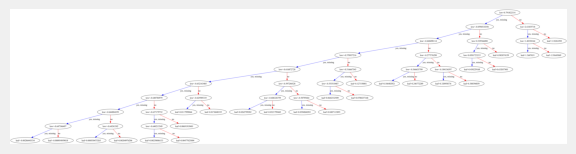

In [38]:
#Apply visualization to our model
plt.figure(figsize=(25,25))
plot_tree(model,fontsize=15)
plt.show();

In [39]:
#clearly show the quality of the model's work with the help of a table
prediction = pd.DataFrame(model.predict(dtest_reg),index=y_valid.index)
test_answer= pd.concat([y_valid,prediction],axis=1,ignore_index=True)
test_answer = test_answer.rename(columns={0: 'y_valid', 1:"prediction"})
test_answer

,y_valid,prediction
Date,,
2010-08-19,6.378500,6.410802
2011-04-11,9.202000,9.222663
2004-12-14,2.022000,2.014422
2015-12-30,34.453499,34.513332
2002-08-27,0.726000,0.747685
...,...,...
2017-03-17,42.615501,42.609547
2002-12-16,1.125500,1.115762
2002-10-29,0.928500,0.935785


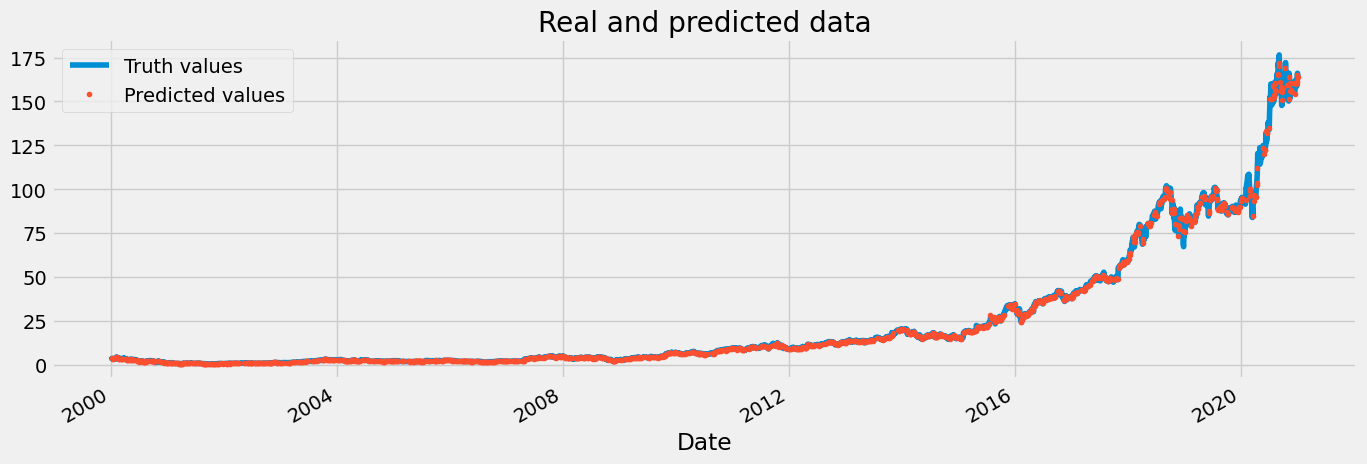

In [40]:
#Also with the help of visualization
ax = df['close'].plot(figsize=(15,5))
prediction.plot(ax=ax,style='.')
plt.legend(['Truth values','Predicted values'])
ax.set_title('Real and predicted data')
plt.show()

> It can be seen from the last graph that the model performed the task quite well, now I suggest to start working on creating another model and see how it will work.


In [41]:
#loading tensorboard
%load_ext tensorboard

In [42]:
try:# download another data set with share prices and their number for the company "Google" 
    company = "GOOG"
    # Specify the time interval 
    start = "2005-01-01"
    end = "2022-01-01"
    #loading data set
    df = yf.download(company,start,end)
    print(df.head(5))
    print(df.shape)
except:
    print("Try again")

[*********************100%%**********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2005-01-03  4.916571  5.071989  4.868253  5.048826   5.048826  636143518
2005-01-04  5.016198  5.054305  4.818937  4.844342   4.844342  552298420
2005-01-05  4.818190  4.904118  4.787804  4.819685   4.819685  330698912
2005-01-06  4.858788  4.879212  4.675475  4.696148   4.696148  417041336
2005-01-07  4.748203  4.838116  4.701876  4.828153   4.828153  387964757
(4280, 6)


In [43]:
print(f'Number of missing values: {df.isnull().sum()}')
print()
print(f'Number of duplicates in data : {df.duplicated().sum()}')

Number of missing values: Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Number of duplicates in data : 0


> Yes, I have already analyzed the path from **Data preprocessing -> Data preparation for training**, I suggest to immediately destandardize the data, start working with the neuron


In [44]:
#Changing the name of the future to the lower case
df.columns = df.columns.str.lower()
df

,open,high,low,close,adj close,volume
Date,,,,,,
2005-01-03,4.916571,5.071989,4.868253,5.048826,5.048826,636143518
2005-01-04,5.016198,5.054305,4.818937,4.844342,4.844342,552298420
2005-01-05,4.818190,4.904118,4.787804,4.819685,4.819685,330698912
2005-01-06,4.858788,4.879212,4.675475,4.696148,4.696148,417041336
2005-01-07,4.748203,4.838116,4.701876,4.828153,4.828153,387964757
...,...,...,...,...,...,...
2021-12-27,147.463501,148.426498,147.250000,148.063995,148.063995,13256000
2021-12-28,148.374496,148.374496,145.935501,146.447998,146.447998,18624000
2021-12-29,146.429504,147.183746,145.504501,146.504501,146.504501,17022000


In [45]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1,1))

In [46]:

#Set the number of days used for the forecast
prediction_days = 60
#Initialization of empty lists for input and output training
x_train = []
y_train = []

# I go through the scaled data, starting with the prediction_days index
for x in range(prediction_days, len(scaled_data)):
    # add previous values of 'prediction_days' to x_train
    x_train.append(scaled_data[x - prediction_days:x, 0])
    # add the current value to y_train
    y_train.append(scaled_data[x, 0])
#convert x_train and y_train lists into numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#change the shape of x_train to a 3D array with the appropriate dimensions for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [47]:
#adding a tool for visualizing the work of my model, which will show how the indicators of the quality of the model work change after each epoch
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [48]:
# start building the model
def LSTM_model():

    # Initialization of the sequential model
    model = models.Sequential()

    # add the first LSTM layer with 50 units, input shape and return sequences
    model.add(layers.LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # add dropouts to prevent overfitting
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(units=50, return_sequences=True))
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(units=50))
    model.add(layers.Dropout(0.2))

    # The final output layer for price prediction
    model.add(layers.Dense(units=1))

    return model

In [49]:
#set the model and add an optimizer and a loss function to it
model = LSTM_model()
model.summary()
model.compile(
    optimizer='adam', 
    loss='mean_squared_error'
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [50]:
%%time

#start working with the model
model.fit(
    x_train, 
    y_train, 
    epochs=25, 
    batch_size = 32,
    callbacks = [tensorboard_callback]
)

Epoch 1/25
132/132 [==============================] - 5s 28ms/step - loss: 0.0044
Epoch 2/25
132/132 [==============================] - 4s 28ms/step - loss: 0.0010
Epoch 3/25
132/132 [==============================] - 4s 28ms/step - loss: 9.5317e-04
Epoch 4/25
132/132 [==============================] - 4s 28ms/step - loss: 9.5689e-04
Epoch 5/25
132/132 [==============================] - 4s 28ms/step - loss: 8.5601e-04
Epoch 6/25
132/132 [==============================] - 4s 28ms/step - loss: 7.3962e-04
Epoch 7/25
132/132 [==============================] - 4s 28ms/step - loss: 7.4884e-04
Epoch 8/25
132/132 [==============================] - 4s 28ms/step - loss: 6.7200e-04
Epoch 9/25
132/132 [==============================] - 4s 29ms/step - loss: 7.1369e-04
Epoch 10/25
132/132 [==============================] - 4s 28ms/step - loss: 5.9483e-04
Epoch 11/25
132/132 [==============================] - 4s 28ms/step - loss: 6.8679e-04
Epoch 12/25
132/132 [==============================] - 4s 29

In [51]:
#Download tensorboard

%tensorboard --logdir logs/fit

- After training this model, it can be seen that it is possible to add a few more epochs to improve the performance of the model, but in principle this value of **loss** completely satisfies me

## Checking the accuracy of the model

In [52]:
# Load testing data
company = "GOOG"
#Add time interval 
start = "2022-01-01"
end = "2023-10-01"

test_data = yf.download(company,start,end)
print(test_data.head(5))
print(test_data.shape)


[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-01-03  144.475494  145.550003  143.502502  145.074493  145.074493   
2022-01-04  145.550507  146.610001  143.816147  144.416504  144.416504   
2022-01-05  144.181000  144.298004  137.523499  137.653503  137.653503   
2022-01-06  137.497498  139.686005  136.763504  137.550995  137.550995   
2022-01-07  137.904999  138.254745  135.789001  137.004501  137.004501   

              Volume  
Date                  
2022-01-03  25214000  
2022-01-04  22928000  
2022-01-05  49642000  
2022-01-06  29050000  
2022-01-07  19408000  
(438, 6)


In [53]:
#Extracting actual "Close" prices from test data
actual_prices = test_data['Close'].values

#Combining training and test data in the "Close" column.
total_dataset = pd.concat((df['close'], test_data['Close']), axis=0)

#Extracting the relevant part of the data set for the input data of the model
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

#Reshaping the model input data into a 2D array with one column
model_inputs = model_inputs.reshape(-1, 1)

# applying the same scaling that I used when training the model to the input data of the model
model_inputs = scaler.transform(model_inputs)

In [54]:
##Initialize an empty list for learning input and output
x_test = []

# go through the scaled data, starting with the prediction_days index
for x in range(prediction_days, len(model_inputs)):
    #add previous values of 'prediction_days' to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])

#Convert x_train and y_train lists into numpy arrays
x_test = np.array(x_test)

#Reshape x_train into a 3D array with appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
#Generating predictive prices
predicted_prices = model.predict(x_test)

#Inverting the scaling applied to the forecast prices to get the actual values
predicted_prices = scaler.inverse_transform(predicted_prices)


14/14 [==============================] - 0s 7ms/step


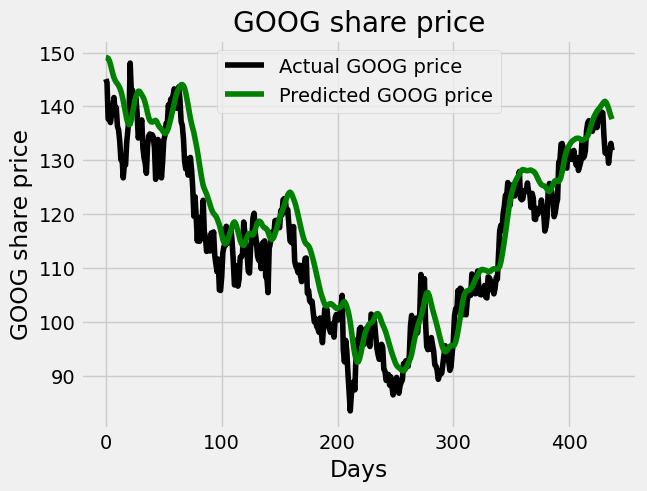

In [55]:
#visualize the actual prices marked with a black line
plt.plot(actual_prices, color='black', label=f"Actual {company} price")

#visualize the forecasted prices marked with a green line
plt.plot(predicted_prices, color='green', label=f"Predicted {company} price")

#set the company name using the "company" change
plt.title(f"{company} share price")

#set the X-axis label as "days"
plt.xlabel("Days")

#set the Y-axis label as "company name"
plt.ylabel(f"{company} share price")

#display a legend to distinguish between actual and forecasted prices
plt.legend()

#display the graph on the screen
plt.show()

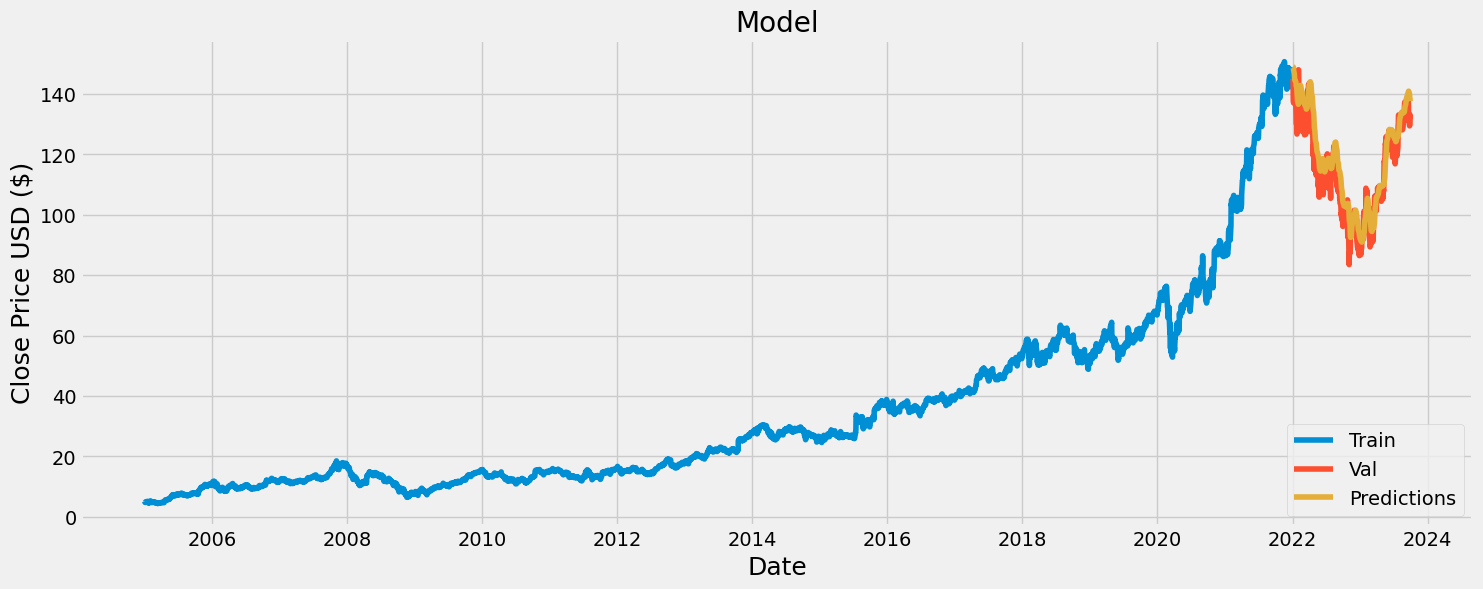

In [56]:
#Adding a little visualization to the model's work
train = df['close']
test_data['Predictions'] = predicted_prices
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train)
plt.plot(test_data[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [57]:
#Checking how the model predicts the price for the next day
# Extract the latest 'prediction_days' values from the model input
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]

#converting real_data to  numpy
real_data = np.array(real_data)

#Changing the shape of real_data to a 3D array with appropriate dimensions for the LSTM model
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

#generating a forecast using an LSTM model with real_data input
prediction = model.predict(real_data)

#Inverting the scaling applied to the prediction to get the actual value
prediction = scaler.inverse_transform(prediction)

#Displaying the predicted result on the screen
print(f"Prediction: {prediction[0][0]}")

1/1 [==============================] - 0s 493ms/step
Prediction: 137.19451904296875


In [58]:
#Check how correct my prediction values to truth
inv = scaler.inverse_transform(model_inputs)
print(f'Our truth value : {inv[-1]}')


Our truth value : [131.8500061]


## Working with pre-trained models

### 1) Preparation of data for working with the model

In [59]:
try:# In this part I working with Netflix data
    company_name= 'NFLX'
    start = "2000-01-01"
    end = "2022-01-01"
    df = yf.download(company_name,start,end)
    df.reset_index(inplace=True)
    print(df)
except:
    print("Перевірь чи все вірно")

[*********************100%%**********************]  1 of 1 completed
           Date        Open        High         Low       Close   Adj Close  \
0    2002-05-23    1.156429    1.242857    1.145714    1.196429    1.196429   
1    2002-05-24    1.214286    1.225000    1.197143    1.210000    1.210000   
2    2002-05-28    1.213571    1.232143    1.157143    1.157143    1.157143   
3    2002-05-29    1.164286    1.164286    1.085714    1.103571    1.103571   
4    2002-05-30    1.107857    1.107857    1.071429    1.071429    1.071429   
...         ...         ...         ...         ...         ...         ...   
4933 2021-12-27  615.000000  615.000000  609.250000  613.119995  613.119995   
4934 2021-12-28  614.950012  618.409973  609.690002  610.710022  610.710022   
4935 2021-12-29  610.710022  613.979980  604.679993  610.539978  610.539978   
4936 2021-12-30  612.989990  620.609985  611.239990  612.090027  612.090027   
4937 2021-12-31  610.010010  614.080017  602.049988  602.44000

In [60]:
#Split my data set on training and test 
train = df.iloc[:len(df)-365]
test = df.iloc[len(df)-365:]
print(train.shape)
print(test.shape)

(4573, 7)
(365, 7)


In [61]:
#Assign necessary variables 
n_years = st.slider('Years of prediction:', 1, 4)
period = n_years * 365


df_train =train[['Date','Close']]#Fetching necessary futures 
df_train = df_train.rename(columns={"Date": "ds", "Close": "y"})#Changing name of futures that I can start working with model
df_test = test[['Date','Close']]
df_test = df_test.rename(columns={"Date": "ds", "Close": "y"})
m = Prophet()
m.fit(df_train)
future = m.make_future_dataframe(periods=period)#function takes a model object and several periods to forecast and creates a corresponding dataframe.
forecast = m.predict(future)#Predicting prices

forecast.head()

2023-10-15 22:35:08.279 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`
2023-10-15 22:35:08.546 
  command:

    streamlit run /Users/volodymyrbondarenko/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py [ARGUMENTS]
22:35:08 - cmdstanpy - INFO - Chain [1] start processing
22:35:09 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2002-05-23,1.297264,-22.254510,37.501290,1.297264,1.297264,5.475753,5.475753,5.475753,0.091133,0.091133,0.091133,5.384620,5.384620,5.384620,0.0,0.0,0.0,6.773017
1,2002-05-24,1.298535,-23.183089,36.374171,1.298535,1.298535,5.329518,5.329518,5.329518,-0.145580,-0.145580,-0.145580,5.475099,5.475099,5.475099,0.0,0.0,0.0,6.628053
2,2002-05-28,1.303620,-22.615429,36.051669,1.303620,1.303620,5.853900,5.853900,5.853900,0.091735,0.091735,0.091735,5.762165,5.762165,5.762165,0.0,0.0,0.0,7.157519
3,2002-05-29,1.304891,-21.142296,38.043177,1.304891,1.304891,5.898500,5.898500,5.898500,0.090093,0.090093,0.090093,5.808407,5.808407,5.808407,0.0,0.0,0.0,7.203391
4,2002-05-30,1.306162,-22.541810,38.656906,1.306162,1.306162,5.934178,5.934178,5.934178,0.091133,0.091133,0.091133,5.843045,5.843045,5.843045,0.0,0.0,0.0,7.240340


In [62]:
#Add a bit of visualisation
plot_plotly(m,forecast)

In [63]:
#Visualizing the components of my projected prices
plot_components_plotly(m,forecast)

In [64]:
#Featching futures
forecast[["ds","yhat","yhat_lower","yhat_upper"]]

,ds,yhat,yhat_lower,yhat_upper
0,2002-05-23,6.773017,-22.254510,37.501290
1,2002-05-24,6.628053,-23.183089,36.374171
2,2002-05-28,7.157519,-22.615429,36.051669
3,2002-05-29,7.203391,-21.142296,38.043177
4,2002-05-30,7.240340,-22.541810,38.656906
...,...,...,...,...
4933,2021-07-18,514.987747,483.750351,544.175785
4934,2021-07-19,514.707421,485.766191,547.343589
4935,2021-07-20,514.506004,482.968932,543.222092
4936,2021-07-21,514.161309,484.619438,543.822007


In [65]:
#Checking accuracy of the model
predictions = forecast.iloc[-365:]["yhat"]
print(f"The root mean square error between the actual and predicted values: {rmse(predictions,df_test['y'])}")

The root mean square error between the actual and predicted values: 82.7959206225239


## Overall conclusion:
Tasks of this project:
> Forecast future stock prices of any 2 (two) companies of your choice based on historical data.

### I divided the work of this project into several stages:
1) At the first stage of work, I downloaded all the necessary libraries and tools, which I then used for work

2) Data preprocessing:
- First, I downloaded the data set using the open resource **yahoo finance**, for the data set I selected the stock prices of the company ***Amazon***
- After checking that my data set is clean, has no duplicates, and all futures have the type I need, I proceeded to the next step

3) Exploration Data Analysis:
- Using the "describe" function, I received a statistical analysis of my data set and saw that, in principle, the values in all price futures are approximately the same
- After adding visualizations, I analyzed the main prices of shares and saw a pattern that before **2012** the rate of change of prices was almost not strong, and after **2012** I saw that they went up quite sharply and had peak values for a while, then there were also moments decrease, but after **2016** began to rapidly move upwards
- I also determined with the help of box plots that the number of extreme values before **2016** was more than after, which means that the distribution of stock prices after **2016** is better
- I also determined that before **2012** the number of shares sold was more than after
- I created a function that split my dates in indices into years, months and days, for further work with them
- With the help of a correlation heat map, I determined which futures our target variable depends on the most

4) Data preparation: data preparation for working with the model
- First, I divided our data set into training and target
- Then I normalized the data using **StandardScaler**
- After that, using the **Filter and Wrapped** methods for determining the best futures in the data set, I chose those that I will work with further

5) Working with models: in this project I defined two types of models with which I worked
- Using the method of automatic selection of hyperparameters, **Optuna** determined the best hyperparameters for the operation of my model
- Further, after preparing the data for work with the ***XGBoost*** algorithm, I determined that the ***MAE: for the XGB model is: 0.46 and the working time is 1.2 seconds***
- After constructing the graph, I made sure that my model works quite well
- The next step was to create a ***LSTM*** neural model for predicting prices depending on the previous ones, here I chose to predict 60 days, that is, my model takes data from the previous 60 days and predicts the price for 61 days, etc. To work with this model, I use a data set of prices for shares of the company **GooGle**
- After preparing and normalizing the data, I started working with the model and found that this model works longer than **XGboost**, the working time was **93s.**, but it has a greater accuracy **0.00053**, I made sure of this by constructing graphs , also in the last step I extracted the last 60 values from my data set, and predicted the following, clearly showing how well my model predicted by extracting the true value from my data set.


## Additionally:
- Demonstrated how it is possible to use **open access software** to also predict prices
- In such cases, it is also possible to work with **LLM** models, but for this the main time and complexity is data preparation, but they also have a good final result, one of these models is quite popular from **HuggingFace** link: https:/ /huggingface.co/blog/time-series-transformers